In [71]:
from descriptive_statistics import DiabetesDataBase
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from utils import grid_search, halving_random_search, validate
import numpy as np

## Hyperparameters

In [72]:
normalization_method = "Q" # ("S", "R", "Q") S for standard, R for robust, Q for quantile
match normalization_method:
    case "S":
        SCALER = StandardScaler()
    case "R":
        SCALER = RobustScaler() #Eliminated never better than S or Q and take 
    case "Q":
        SCALER = QuantileTransformer(n_quantiles=334)

RANDOM_STATE = 17

## Tensorboard

In [73]:
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime

time = datetime.now().strftime("%Y%B%d_%H_%M")
print(time)
log_folder = "logs/"+time+normalization_method+str(RANDOM_STATE)
writer = SummaryWriter(log_dir=log_folder)

2024May24_09_15


## Read in and split data

In [74]:
csv_path = "diabetes.csv"
ddb = DiabetesDataBase(csv_path, train_split=0.8, val_split=0.1, test_split=0.1, random_state=RANDOM_STATE, augment=True)
X_train, X_val, X_test, y_train, y_val, y_test = ddb.get_splits()

/Users/emillundin/Desktop/M7016H/M7016H-Project/descriptive_statistics.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '121    6.027627
291    0.014868
190    3.131488
454    1.919364
419    3.010386
         ...   
110    2.808813
90     1.065747
721    1.043558
393    3.988361
521    3.013364
Name: Pregnancies, Length: 584, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_augmented.iloc[:, :-1] = train_augmented.iloc[:, :-1] + noise
/Users/emillundin/Desktop/M7016H/M7016H-Project/descriptive_statistics.py:72: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '121    23.963790
291    24.822472
190    20.955335
454    23.986141
419    27.796401
         ...    
110    23.890044
90     21.094066
721    21.041217
393    37.013021
521    25.872425
Name: Age, Length: 584, dtype: float64' 

## KNN Model

KNeighborsClassifier(metric='manhattan', n_neighbors=1)
              precision    recall  f1-score   support

           0       0.73      0.86      0.79        44
           1       0.71      0.52      0.60        29

    accuracy                           0.73        73
   macro avg       0.72      0.69      0.70        73
weighted avg       0.72      0.73      0.72        73



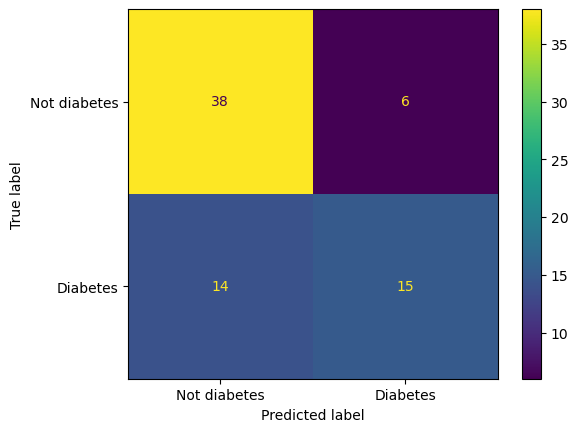

In [75]:
knn = KNeighborsClassifier()

parameters = {
    "classifier__n_neighbors": list(range(1, 31)),
    "classifier__metric": ['euclidean','manhattan'],
    "classifier__weights":['uniform','distance']
}

knn_cls = grid_search(knn, SCALER, parameters)

knn_cls.fit(X_train, y_train)

print(knn_cls.best_estimator_.get_params()['classifier'])

knn_avg, knn_cm = validate(knn_cls, X_val, y_val)
writer.add_scalars("knn", knn_avg)
writer.flush()

## Random Forest

/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=800,
                       random_state=17)
              precision    recall  f1-score   support

           0       0.73      0.91      0.81        44
           1       0.78      0.48      0.60        29

    accuracy                           0.74        73
   macro avg       0.75      0.70      0.70        73
weighted avg       0.75      0.74      0.72        73



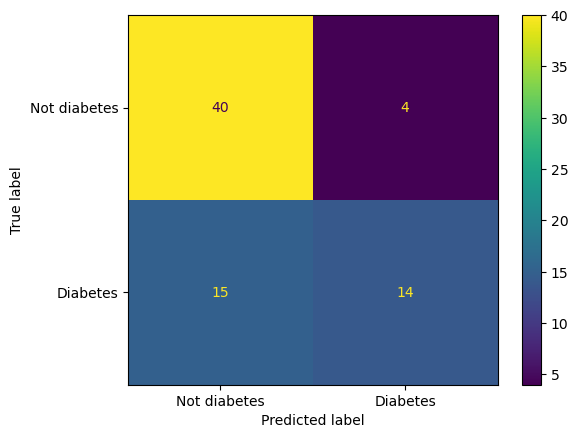

In [76]:
random_forest = RandomForestClassifier(random_state = RANDOM_STATE)

# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
parameters = {
    
    "classifier__n_estimators": [int(x) for x in np.linspace(start = 100, stop = 1000, num = 100)],
    "classifier__max_features": ['log2', 'sqrt'],
    "classifier__max_depth" : [int(x) for x in np.linspace(10, 110, num = 11)],
    "classifier__min_samples_split": [2,5,10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__bootstrap": [True, False],
}

random_forest_cls = halving_random_search(random_forest, SCALER, parameters, random_state=RANDOM_STATE)

random_forest_cls.fit(X_train, y_train)

print(random_forest_cls.best_estimator_.get_params()['classifier'])

random_forest_avg, random_forest_cm = validate(random_forest_cls, X_val, y_val)
writer.add_scalars("random_forest", random_forest_avg)
writer.flush()

## Logistic Regression

LogisticRegression()
              precision    recall  f1-score   support

           0       0.74      0.89      0.80        44
           1       0.75      0.52      0.61        29

    accuracy                           0.74        73
   macro avg       0.74      0.70      0.71        73
weighted avg       0.74      0.74      0.73        73



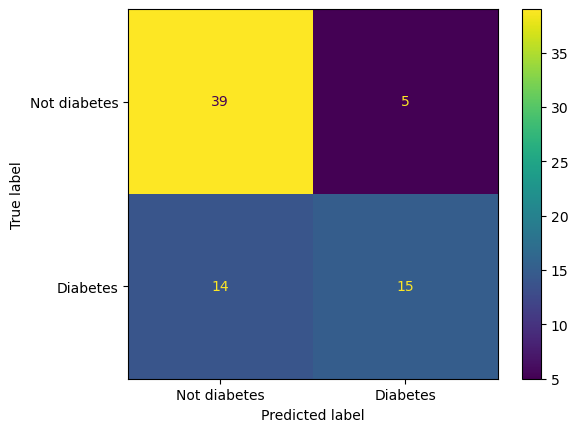

In [77]:
log_reg = LogisticRegression()

parameters = {
    "classifier__penalty": [None, "l2"]
}

reg_cls = grid_search(log_reg, SCALER, parameters)

reg_cls.fit(X_train, y_train)

print(reg_cls.best_estimator_.get_params()['classifier'])

log_reg_avg, log_reg_cm = validate(reg_cls, X_val, y_val)
writer.add_scalars("log_reg", log_reg_avg)
writer.flush()

## SVM

{'classifier__C': [0.01, 0.1, 1, 10, 100], 'classifier__gamma': [0.01, 0.1, 1, 10, 100], 'classifier__kernel': ['linear', 'rbf', 'sigmoid']}
SVC(C=10, gamma=10)
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        44
           1       0.69      0.38      0.49        29

    accuracy                           0.68        73
   macro avg       0.69      0.63      0.63        73
weighted avg       0.69      0.68      0.66        73



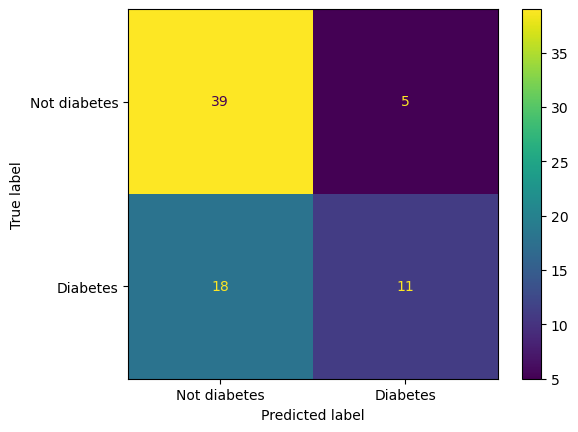

In [78]:
from sklearn.svm import SVC

svm = SVC()

parameters = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__gamma": [0.01, 0.1, 1, 10, 100],
    "classifier__kernel": ["linear", "rbf", "sigmoid"]
}
print(parameters)


svm_cls = grid_search(svm, SCALER, parameters)
svm_cls.fit(X_train, y_train)
print(svm_cls.best_estimator_.get_params()['classifier'])

svm_avg, svm_cm = validate(svm_cls, X_val, y_val)
writer.add_scalars("svm", svm_avg)
writer.flush()

## MLP

{'classifier__solver': ['adam', 'sgd'], 'classifier__activation': ['relu', 'tanh', 'logistic'], 'classifier__learning_rate_init': [0.0001, 0.001, 0.01, 0.005], 'classifier__hidden_layer_sizes': [[10, 10], [100, 10], [50, 100, 50], [100], [10]], 'classifier__beta_1': [0.09, 0.091, 0.092, 0.093, 0.094], 'classifier__beta_2': [0.985, 0.988, 0.991, 0.994, 0.997]}


/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (15). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs/ptlightning/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2764: UserWarning: n_quantiles (334) is greater than the total number of samples (16). n_quantiles is set to n_samples.
  warnings.warn(
/Users/emillundin/anaconda3/envs

MLPClassifier(activation='tanh', beta_1=0.093, beta_2=0.994,
              early_stopping=True, hidden_layer_sizes=[10, 10],
              learning_rate_init=0.01, max_iter=30000, random_state=17,
              solver='sgd')
              precision    recall  f1-score   support

           0       0.73      0.84      0.78        44
           1       0.68      0.52      0.59        29

    accuracy                           0.71        73
   macro avg       0.70      0.68      0.68        73
weighted avg       0.71      0.71      0.70        73



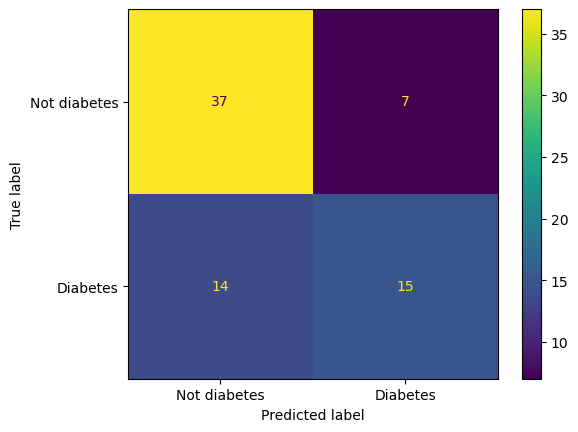

In [79]:
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV


mlp = MLPClassifier(activation='relu', #relu
                    solver='adam', 
                    max_iter=30000, #300000
                    batch_size='auto',
                    learning_rate_init=0.001,
                    # Early stopping kinda does CV too https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
                    early_stopping=True,
                    shuffle=True,
                    random_state=RANDOM_STATE,
                    alpha=0.0001, # L2 loss strenght
                    beta_1=0.9, # 0.9 org Exponential decay rate for estimates of first moment vector in adam
                    beta_2=0.999, # 0.999 org Exponential decay rate for estimates of second moment vector in adam
                    epsilon=1e-8 # 1e-8 org Value for numerical stability in adam.
                    )

parameters = {
    "classifier__solver": ["adam", "sgd"],
    "classifier__activation": ["relu", "tanh", "logistic"],
    "classifier__learning_rate_init": [0.0001, 0.001, 0.01, 0.005],
    "classifier__hidden_layer_sizes": [[10,10], [100,10], [50,100,50], [100], [10]],
    "classifier__beta_1": [round(i*0.001, 3) for i in range(90, 95)],
    "classifier__beta_2": [round(i*0.001, 4) for i in range(985, 999, 3)]
}
print(parameters)

mlp_cls = halving_random_search(mlp, SCALER, parameters, random_state=RANDOM_STATE)

mlp_cls.fit(X_train, y_train)

print(mlp_cls.best_estimator_.get_params()['classifier'])

mlp_avg, mlp_cm = validate(mlp_cls, X_val, y_val)
writer.add_scalars("mlp", mlp_avg)
writer.flush()
writer.close()

In [80]:
%load_ext tensorboard
%tensorboard --logdir=logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 16166), started 16:35:04 ago. (Use '!kill 16166' to kill it.)